# Analyzing Stock Sentiment from Twits

### Load Packages

In [1]:
import json
import nltk
import os
import random
import re
import torch
import numpy as np
from nltk.corpus import stopwords
from torch import nn, optim
import torch.nn.functional as F


## Introduction
When deciding the value of a company, it's important to follow the news. For example, a product recall or natural disaster in a company's product chain. You want to be able to turn this information into a signal. Currently, the best tool for the job is a Neural Network. 

I'll use posts from the social media site [StockTwits](https://en.wikipedia.org/wiki/StockTwits). The community on StockTwits is full of investors, traders, and entrepreneurs. Each message posted is called a Twit. This is similar to Twitter's version of a post, called a Tweet. I'll build a model around these twits that generate a sentiment score.

To capture the degree of sentiment, a five-point scale was used: very negative, negative, neutral, positive, very positive. Each twit is labeled -2 to 2 in steps of 1, from very negative to very positive respectively. I'll build a sentiment analysis model that will learn to assign sentiment to twits on its own, using this labeled data.



## Import Twits 
### Load Twits Data 
This JSON file contains a list of objects for each twit in the `'data'` field:

```
{'data':
  {'message_body': 'Neutral twit body text here',
   'sentiment': 0},
  {'message_body': 'Happy twit body text here',
   'sentiment': 1},
   ...
}
```

The fields represent the following:

* `'message_body'`: The text of the twit.
* `'sentiment'`: Sentiment score for the twit, ranges from -2 to 2 in steps of 1, with 0 being neutral.

In [2]:
with open(os.path.join('..', '..', 'data', 'project_6_stocktwits', 'twits.json'), 'r') as f:
    twits = json.load(f)

print(twits['data'][:10])

[{'message_body': '$FITB great buy at 26.00...ill wait', 'sentiment': 2, 'timestamp': '2018-07-01T00:00:09Z'}, {'message_body': '@StockTwits $MSFT', 'sentiment': 1, 'timestamp': '2018-07-01T00:00:42Z'}, {'message_body': '#STAAnalystAlert for $TDG : Jefferies Maintains with a rating of Hold setting target price at USD 350.00. Our own verdict is Buy  http://www.stocktargetadvisor.com/toprating', 'sentiment': 2, 'timestamp': '2018-07-01T00:01:24Z'}, {'message_body': '$AMD I heard there’s a guy who knows someone who thinks somebody knows something - on StockTwits.', 'sentiment': 1, 'timestamp': '2018-07-01T00:01:47Z'}, {'message_body': '$AMD reveal yourself!', 'sentiment': 0, 'timestamp': '2018-07-01T00:02:13Z'}, {'message_body': '$AAPL Why the drop? I warren Buffet taking out his position?', 'sentiment': 1, 'timestamp': '2018-07-01T00:03:10Z'}, {'message_body': '$BA bears have 1 reason on 06-29 to pay more attention https://dividendbot.com?s=BA', 'sentiment': -2, 'timestamp': '2018-07-01T

### Length of Data

In [3]:
"""print out the number of twits"""

print(len(twits['data']))

1548010


### Split Message Body and Sentiment Score

In [4]:
messages = [twit['message_body'] for twit in twits['data']]

# Since the sentiment scores are discrete, we'll scale the sentiments to 0 to 4 for use in our network
sentiments = [twit['sentiment'] + 2 for twit in twits['data']]

In [5]:
messages[:10]

['$FITB great buy at 26.00...ill wait',
 '@StockTwits $MSFT',
 '#STAAnalystAlert for $TDG : Jefferies Maintains with a rating of Hold setting target price at USD 350.00. Our own verdict is Buy  http://www.stocktargetadvisor.com/toprating',
 '$AMD I heard there’s a guy who knows someone who thinks somebody knows something - on StockTwits.',
 '$AMD reveal yourself!',
 '$AAPL Why the drop? I warren Buffet taking out his position?',
 '$BA bears have 1 reason on 06-29 to pay more attention https://dividendbot.com?s=BA',
 '$BAC ok good we&#39;re not dropping in price over the weekend, lol',
 '$AMAT - Daily Chart, we need to get back to above 50.',
 '$GME 3% drop per week after spike... if no news in 3 months, back to 12s... if BO, then bingo... what is the odds?']

In [6]:
set(sentiments)

{0, 1, 2, 3, 4}

## Preprocessing the Data
With the data in hand I will preprocess our text. These twits are collected by filtering on ticker symbols where these are denoted with a leader $ symbol in the twit itself. For example,

`{'message_body': 'RT @google Our annual look at the year in Google blogging (and beyond) http://t.co/sptHOAh8 $GOOG',
 'sentiment': 0}`

The ticker symbols don't provide information on the sentiment, and they are in every twit, so I will remove them. This twit also has the `@google` username, again not providing sentiment information, so I should also remove it. I also see a URL `http://t.co/sptHOAh8`. I'll remove these too.

### Pre-Processing

In [7]:
nltk.download('wordnet')
nltk.download("stopwords", quiet=True)


def preprocess(message):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - tokenize by splitting the string on whitespace 
        - removes any single character tokens
    
    Parameters
    ----------
        message : The text message to be preprocessed.
        
    Returns
    -------
        tokens: The preprocessed text into tokens.
    """ 
    
    # Lowercase the twit message
    text = message.lower()
    
    # Replace URLs with a space in the message
    text = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', ' ', text)
    
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub(r'^\$[A-Z]+', ' ', text)
    
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    text = re.sub(r'^\@\w+', ' ', text)

    # Replace everything not a letter with a space
    text = re.sub(r'[^A-Za-z]', ' ', text)
    
    # Tokenize by splitting the string on whitespace into a list of words
    tokens = text.split(' ')

    # Lemmatize words using the WordNetLemmatizer. You can ignore any word that is not longer than one character.
    wnl = nltk.stem.WordNetLemmatizer()
    tokens = [wnl.lemmatize(w) for w in tokens]
    
    return tokens

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### Preprocess All the Twits 

In [8]:
tokenized = [preprocess(m) for m in messages]

### Bag of Words

In [9]:
from collections import Counter

"""
Create a vocabulary by using Bag of words
"""
    
bow = Counter(word for message in tokenized for word in message)

### Frequency of Words Appearing in Message
With the vocabulary, now I'll remove some of the most common words such as 'the', 'and', 'it', etc. These words don't contribute to identifying sentiment and are really common, resulting in a lot of noise in our input. If I can filter these out, then the network should have an easier time learning. I also want to remove really rare words that show up in a only a few twits. 

In [10]:
"""
Set the following variables:
    freqs
    low_cutoff
    high_cutoff
    K_most_common
"""

# Dictionart that contains the Frequency of words appearing in messages.
# The key is the token and the value is the frequency of that word in the corpus.
total = sum(bow.values())

freqs = {k: np.log(v/total) for k, v in bow.items()}

freq_list = sorted(list(freqs.values()))

In [11]:
# Float that is the frequency cutoff. Drop words with a frequency that is lower or equal to this number.
low_cutoff = np.log(7 * 1e-7)

# Integer that is the cut off for most common words. Drop words that are the `high_cutoff` most common words.
high_cutoff = 20

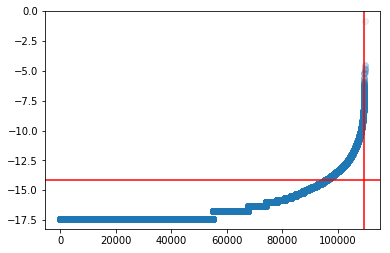

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(freq_list, marker='o', alpha=0.1)
plt.axhline(low_cutoff, color='r')
plt.axvline(len(freq_list) - high_cutoff, color='r')

In [13]:
# The k most common words in the corpus. Use `high_cutoff` as the k.
K_most_common = [k for (k, v) in bow.most_common()[:high_cutoff]]
print(K_most_common)

filtered_words = [word for word in freqs if (freqs[word] > low_cutoff) & (word not in K_most_common)] 

['', 'the', 'to', 'a', 'amp', 'is', 'for', 'utm', 'amd', 'on', 'of', 'and', 'in', 's', 'this', 'it', 'i', 'at', 'mu', 'amzn']


In [14]:
len(freq_list), len(K_most_common), len(filtered_words) 

(109530, 20, 13886)

### Updating Vocabulary by Removing Filtered Words

In [15]:
"""
Set the following variables:
    vocab
    id2vocab
    filtered
"""

# A dictionary for the `filtered_words`. The key is the word and value is an id that represents the word. 
vocab = {word:i for (i, word) in enumerate(filtered_words)}
# Reverse of the `vocab` dictionary. The key is word id and value is the word. 
id2vocab = {v:k for k, v in vocab.items()}

In [16]:
# tokenized with the words not in `filtered_words` removed.
filtered_words_set = set(filtered_words)
filtered = [list(set(message).intersection(filtered_words_set)) for message in tokenized]

### Balancing the classes
50% of the twits are neutral. This means that the network will be 50% accurate just by guessing 0 every single time. To help the network learn appropriately, I'll want to balance our classes. That is, make sure each of the different sentiment scores show up roughly as frequently in the data.

What I can do here is go through each of the examples and randomly drop twits with neutral sentiment. I should also take this opportunity to remove messages with length 0.

In [17]:
balanced = {'messages': [], 'sentiments':[]}

n_neutral = sum(1 for each in sentiments if each == 2)
N_examples = len(sentiments)
keep_prob = (N_examples - n_neutral)/4/n_neutral

for idx, sentiment in enumerate(sentiments):
    message = filtered[idx]
    if len(message) == 0:
        # skip this message because it has length zero
        continue
    elif sentiment != 2 or random.random() < keep_prob:
        balanced['messages'].append(message)
        balanced['sentiments'].append(sentiment) 

In [18]:
n_neutral = sum(1 for each in balanced['sentiments'] if each == 2)
N_examples = len(balanced['sentiments'])
n_neutral/N_examples

0.19825485327766276

In [19]:
# convert tokens into integer ids which can be passed to the network
token_ids = [[vocab[word] for word in message] for message in balanced['messages']]
sentiments = balanced['sentiments']

## Neural Network
Now I have the vocabulary which means I can transform the tokens into ids, which are then passed to our network. I'll define the network.

Here is a diagram showing the network I'd like to build: 

#### Embed -> RNN -> Linear -> Softmax
### Implement the text classifier

In [20]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
class TextClassifier(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size, n_layers=1, drop_prob=0.1):
        """
        Initialize the model by setting up the layers.
        """
        super(TextClassifier, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=False)
        
        # linear layer
        self.fc = nn.Linear(hidden_dim, output_size)

        self.softmax = nn.LogSoftmax(dim=1)        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        x = x.long().to(device)
        embeds = self.embedding(x)

        lstm_out, hidden = self.lstm(embeds, hidden)
        
        # stack up lstm outputs
        lstm_out = lstm_out[-1, :, :]
        fc_out = self.fc(lstm_out)
        soft_out = self.softmax(fc_out)

        return soft_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''

        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden


### View Model

In [23]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab) 
output_size = 5
embedding_dim = 10
hidden_dim = 6
n_layers = 2
drop_prob = 0.1
model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_size, n_layers, drop_prob)
model.to(device)
print(model)

TextClassifier(
  (embedding): Embedding(13886, 10, padding_idx=0)
  (lstm): LSTM(10, 6, num_layers=2, dropout=0.1)
  (fc): Linear(in_features=6, out_features=5, bias=True)
  (softmax): LogSoftmax()
)


In [24]:
batch_size = 4

model.embedding.weight.data.uniform_(-1, 1)
input = torch.randint(0, 1000, (5, 4), dtype=torch.int64)
hidden = model.init_hidden(batch_size)

logps, _ = model.forward(input, hidden)
print(logps)

tensor([[-1.6107, -1.8438, -1.6509, -1.2093, -1.8855],
        [-1.5985, -1.8774, -1.6373, -1.2057, -1.8915],
        [-1.5841, -1.8916, -1.6280, -1.2101, -1.9001],
        [-1.5685, -1.9265, -1.6303, -1.2007, -1.9031]], device='cuda:0')


## Training
### DataLoaders and Batching
Now I'll build a generator that I can use to loop through our data. It'll be more efficient if I can pass our sequences in as batches. The input tensors should look like `(sequence_length, batch_size)`. So if the sequences are 40 tokens long and I pass in 25 sequences, then I'd have an input size of `(40, 25)`.

For messages with fewer than 40 tokens, I will pad the empty spots with zeros. I'll **left** pad so that the RNN starts from nothing before going through the data. If the message has 20 tokens, then the first 20 spots of the 40 long sequence will be 0. If a message has more than 40 tokens, I'll just keep the first 40 tokens.

In [25]:
def dataloader(messages, labels, sequence_length=30, batch_size=32, shuffle=False):
    """ 
    Build a dataloader.
    """
    if shuffle:
        indices = list(range(len(messages)))
        random.shuffle(indices)
        messages = [messages[idx] for idx in indices]
        labels = [labels[idx] for idx in indices]

    total_sequences = len(messages)

    for ii in range(0, total_sequences, batch_size):
        batch_messages = messages[ii: ii+batch_size]
        
        # First initialize a tensor of all zeros
        batch = torch.zeros((sequence_length, len(batch_messages)), dtype=torch.int64)
        for batch_num, tokens in enumerate(batch_messages):
            token_tensor = torch.tensor(tokens)
            # Left pad!
            start_idx = max(sequence_length - len(token_tensor), 0)
            batch[start_idx:, batch_num] = token_tensor[:sequence_length]
        
        label_tensor = torch.tensor(labels[ii: ii+len(batch_messages)])
        
        yield batch, label_tensor

### Training and  Validation
With the data in nice shape, I'll split it into training and validation sets.

In [26]:
"""
Split data into training and validation datasets. Use an appropriate split size.
The features are the `token_ids` and the labels are the `sentiments`.
"""   
size = int(len(token_ids) * 0.8)
train_features = token_ids[:size]
valid_features = token_ids[size:]
train_labels = sentiments[:size]
valid_labels = sentiments[size:]

In [27]:
text_batch, labels = next(iter(dataloader(train_features, train_labels, sequence_length=20, batch_size=64)))

In [28]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab) + 1
output_size = 5
embedding_dim = 200
hidden_dim = 128
n_layers = 2
drop_prob = 0.1
model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_size, n_layers, drop_prob)
model.to(device)
print(model)

TextClassifier(
  (embedding): Embedding(13887, 200, padding_idx=0)
  (lstm): LSTM(200, 128, num_layers=2, dropout=0.1)
  (fc): Linear(in_features=128, out_features=5, bias=True)
  (softmax): LogSoftmax()
)


In [29]:
hidden = model.init_hidden(labels.shape[0])
logps, hidden = model.forward(text_batch, hidden)

### Training

In [30]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab) + 1
output_size = 5
embedding_dim = 1024
hidden_dim = 256
n_layers = 2
drop_prob = 0.2
model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_size, n_layers, drop_prob)
model.embedding.weight.data.uniform_(-1, 1)
model.to(device)
print(model)

TextClassifier(
  (embedding): Embedding(13887, 1024, padding_idx=0)
  (lstm): LSTM(1024, 256, num_layers=2, dropout=0.2)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (softmax): LogSoftmax()
)


In [31]:
# loss and optimization functions
lr=0.001

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [34]:
# training params
epochs = 5
batch_size = 512
counter = 0
print_every = 100
clip=5 # gradient clipping

model.train()

for e in range(epochs):


    # batch loop
    for inputs, labels in dataloader(
            train_features, train_labels, batch_size=batch_size, sequence_length=20, shuffle=True):
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # initialize hidden state
        h = model.init_hidden(labels.shape[0])
        for each in h:
            each.to(device)        

        correct = 0
        total = 1
        
        # zero accumulated gradients
        model.zero_grad()
        
        # get the output from the model
        output, h = model(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels)
        loss.backward()
        
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            
            val_losses = []
            model.eval()
            for inputs, labels in dataloader(
            valid_features, valid_labels, batch_size=batch_size, sequence_length=20, shuffle=True):

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()
                    
                val_h = model.init_hidden(labels.shape[0])
                for each in val_h:
                    each.to(device) 

                
                output, val_h = model(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels)
                val_losses.append(val_loss.item())
                
                _, predicted = torch.max(output.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
            model.train()
            
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)),
                  "Accuracy: {:.6f}".format(correct/total))

Epoch: 1/5... Step: 100... Loss: 0.999000... Val Loss: 1.059158 Accuracy: 0.576685
Epoch: 1/5... Step: 200... Loss: 0.972933... Val Loss: 0.963300 Accuracy: 0.619526
Epoch: 1/5... Step: 300... Loss: 0.841275... Val Loss: 0.929947 Accuracy: 0.631839
Epoch: 1/5... Step: 400... Loss: 0.899137... Val Loss: 0.912087 Accuracy: 0.640206
Epoch: 1/5... Step: 500... Loss: 0.867356... Val Loss: 0.884901 Accuracy: 0.652811
Epoch: 1/5... Step: 600... Loss: 0.837871... Val Loss: 0.878843 Accuracy: 0.652272
Epoch: 1/5... Step: 700... Loss: 0.886134... Val Loss: 0.864575 Accuracy: 0.658429
Epoch: 1/5... Step: 800... Loss: 0.815470... Val Loss: 0.853947 Accuracy: 0.665808
Epoch: 1/5... Step: 900... Loss: 0.823644... Val Loss: 0.852230 Accuracy: 0.666027
Epoch: 1/5... Step: 1000... Loss: 0.792486... Val Loss: 0.845881 Accuracy: 0.665913
Epoch: 1/5... Step: 1100... Loss: 0.811531... Val Loss: 0.845677 Accuracy: 0.665206
Epoch: 1/5... Step: 1200... Loss: 0.769030... Val Loss: 0.836875 Accuracy: 0.669821
E

In [35]:
torch.save(model.state_dict(), 'model.pt')

In [36]:
trained_model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_size, n_layers, drop_prob)
trained_model.load_state_dict(torch.load('model.pt'))

## Making Predictions
### Prediction 

In [37]:
def predict(text, model, vocab):
    """ 
    Make a prediction on a single sentence.

    Parameters
    ----------
        text : The string to make a prediction on.
        model : The model to use for making the prediction.
        vocab : Dictionary for word to word ids. The key is the word and the value is the word id.

    Returns
    -------
        pred : Prediction vector
    """    
    
    tokens = preprocess(text)
    
    # Filter non-vocab words
    tokens = [word for word in tokens if word in vocab]

    # Convert words to ids
    tokens = [vocab[word] for word in tokens]

    # Adding a batch dimension
    text_array = torch.tensor(tokens).view(-1,1)

    # Get the NN output
    hidden = model.init_hidden(1)

    logps, _ = model.forward(text_array, hidden)
    
    # Take the exponent of the NN output to get a range of 0 to 1 for each label.
    prediction = torch.exp(logps)
    
    return prediction

In [38]:
text = "Nashville is going to reopen, which signals increased economic activities"
model.eval()
model.to(device)
predict(text, model, vocab)

tensor([[ 0.0004,  0.0172,  0.0203,  0.5361,  0.4261]], device='cuda:0')

### What is the prediction of the model? What is the uncertainty of the prediction?
The model prediction is a probability distribution of the five classes of the sentiment of the tweet. The class with the highest probability score is the most likely sentiment level based on the model. 

The model is predicting a probability (54%) of the text being positive and being a sentiment of 1. If combining the probabilities on the positive side (54%+43%), the model predicts a positive sentiment overall. Which I agree with intuitively based on the text. The uncertainly of this prediction being 1 is 47%. The uncertainly of this prediction being positive is 3% which is quite low. 


## Testing
Now I have a trained model and I can make predictions. I can use this model to track the sentiments of various stocks by predicting the sentiments of twits as they are coming in. Now I have a stream of twits. For each of those twits, I'll pull out the stocks mentioned in them and keep track of the sentiments. I want to track the sentiments of the stocks in the universe and use this as a signal in the larger model(s).

### Load the Data 

In [39]:
with open(os.path.join('..', '..', 'data', 'project_6_stocktwits', 'test_twits.json'), 'r') as f:
    test_data = json.load(f)

### Twit Stream

In [40]:
def twit_stream():
    for twit in test_data['data']:
        yield twit

next(twit_stream())

{'message_body': '$JWN has moved -1.69% on 10-31. Check out the movement and peers at  https://dividendbot.com?s=JWN',
 'timestamp': '2018-11-01T00:00:05Z'}

Using the `prediction` function, I'll apply it to a stream of twits.

In [41]:
def score_twits(stream, model, vocab, universe):
    """ 
    Given a stream of twits and a universe of tickers, return sentiment scores for tickers in the universe.
    """
    for twit in stream:

        # Get the message text
        text = twit['message_body']
        symbols = re.findall('\$[A-Z]{2,4}', text)
        score = predict(text, model, vocab)

        for symbol in symbols:
            if symbol in universe:
                yield {'symbol': symbol, 'score': score, 'timestamp': twit['timestamp']}

In [42]:
universe = {'$BBRY', '$AAPL', '$AMZN', '$BABA', '$YHOO', '$LQMT', '$FB', '$GOOG', '$BBBY', '$JNUG', '$SBUX', '$MU'}
score_stream = score_twits(twit_stream(), model, vocab, universe)

next(score_stream)


{'symbol': '$AAPL',
 'score': tensor([[ 0.1307,  0.1637,  0.2383,  0.0851,  0.3823]], device='cuda:0'),
 'timestamp': '2018-11-01T00:00:18Z'}